##### Lecture 18: Partial Differential Equations - Parabolic

1. Temperature in a 1-D metal rod

$$\frac{\partial T}{\partial t} = k\frac{\partial^2 T}{\partial x^2}$$

$x \in [0,10]$ cm, $t \in [0,50]$ seconds. Use $\Delta x = 0.2$ cm and $\Delta t = 0.01$ s.

Boundary conditions: $T(0,t) = 100 ^\circ$ C, $T(10,t) = 50 ^\circ$ C

Initial condition: $T(x,0) = 0 ^\circ$ C

- Solve with explicit (FTCS), implicit (BTCS), and Crank-Nicolson
- Compare accuracy against analytical solution: $T(x=2, t=10) = 64.8018$ (C&C Table 30.1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
dx = 0.2 # cm
dt = 0.01 # s
L = 10 # cm
tmax = 50 # s
k = 0.835 # cm^2/s

lmbda  = k * dt/dx**2 # lambda is a reserved keyword in python

x = np.arange(0, L+dx, dx)
t = np.arange(0, tmax+dt, dt)
T  = np.zeros((len(x),len(t)+1))

T[:,0] = 0 # initial condition
T[0,:] = 100 # left BC
T[-1,:] = 50  # right BC 

for l in range(len(t)):
    for i in range(1,len(x)-1):   # i=0 and i=len(x)-1 are BCs
        T[i,l+1] = lmbda * T[i-1,l] + (1 - 2*lmbda) * T[i,l] + lmbda*T[i+1,l]


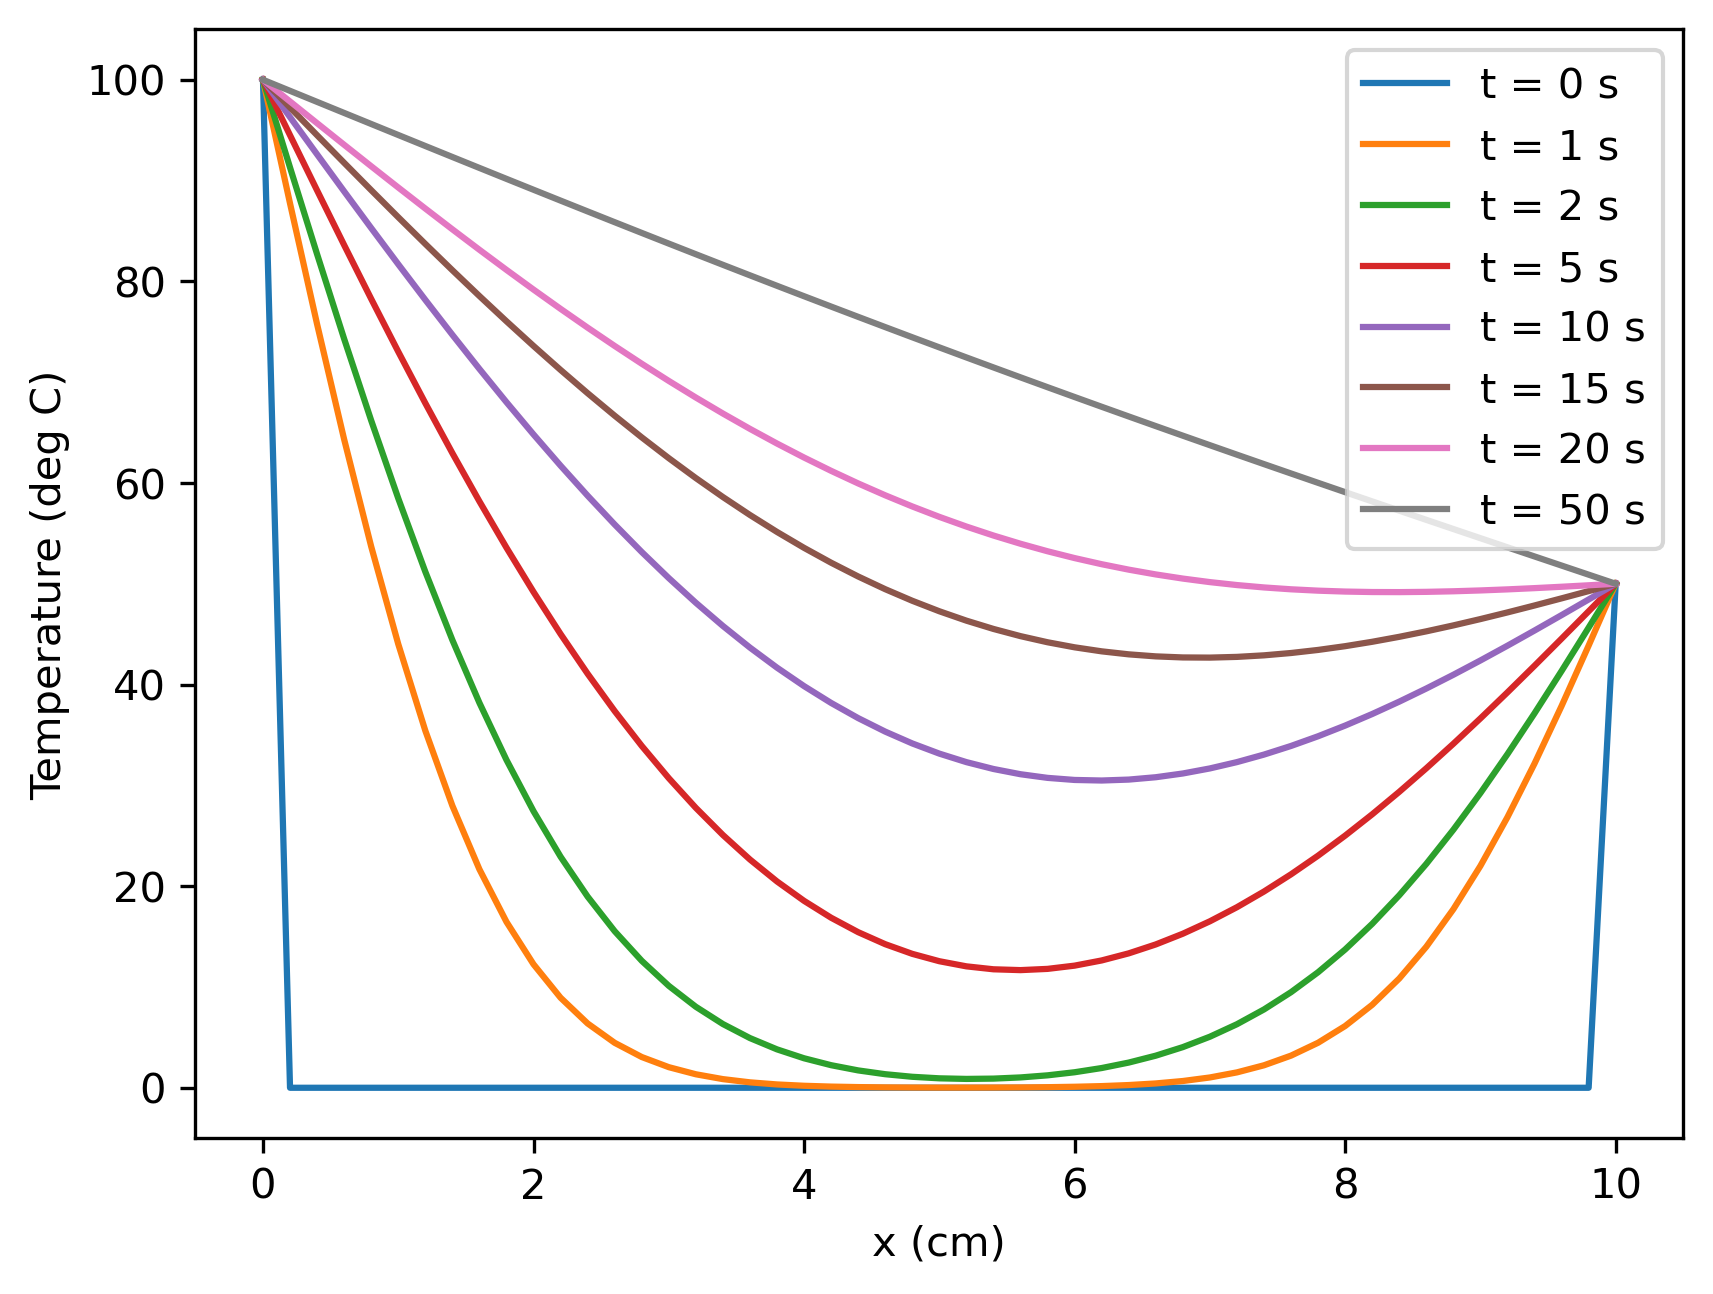

In [3]:
# plot temperature profiles at selected times
times_to_plot = [0, 1, 2, 5, 10, 15, 20, 50] # seconds

for ttp in times_to_plot:
    plt.plot(x, T[:, int(ttp/dt)], label = 't = %d s' % ttp)

plt.xlabel('x (cm)')
plt.ylabel('Temperature (deg C)')
plt.legend()
plt.show()

In [4]:
print(lmbda)

0.20874999999999996


The value $\lambda \leq 1/2$, so the explicit solution is stable. Try making $\Delta x$ smaller or $\Delta t$ larger to create an unstable solution, and see what happens.

In [5]:
T_explicit = T.copy() # save the results for later

------------
##### Implicit Method
2. Implicit (BTCS) method

In [6]:
T  = np.zeros((len(x),len(t)+1))

T[:,0] = 0 # initial condition
T[0,:] = 100 # left BC
T[-1,:] = 50  # right BC 

main = (1 + 2*lmbda) * np.ones(len(x)-2) # length-2 removes BCs
off1 = -lmbda * np.ones(len(x)-3)
A = np.diag(main) + np.diag(off1,-1) + np.diag(off1,1)

# Loop over timesteps and solve system of equations
for l in range(len(t)):
    # b vector is the previous timestep temperatures plus BCs
    b = T[1:-1,l].copy() # internal nodes only
    b[0] += lmbda * 100 # left BC
    b[-1] += lmbda*50 # right BC
     
    T[1:-1,l+1] = np.linalg.solve(A,b) # solve all internal nodes at this timestep


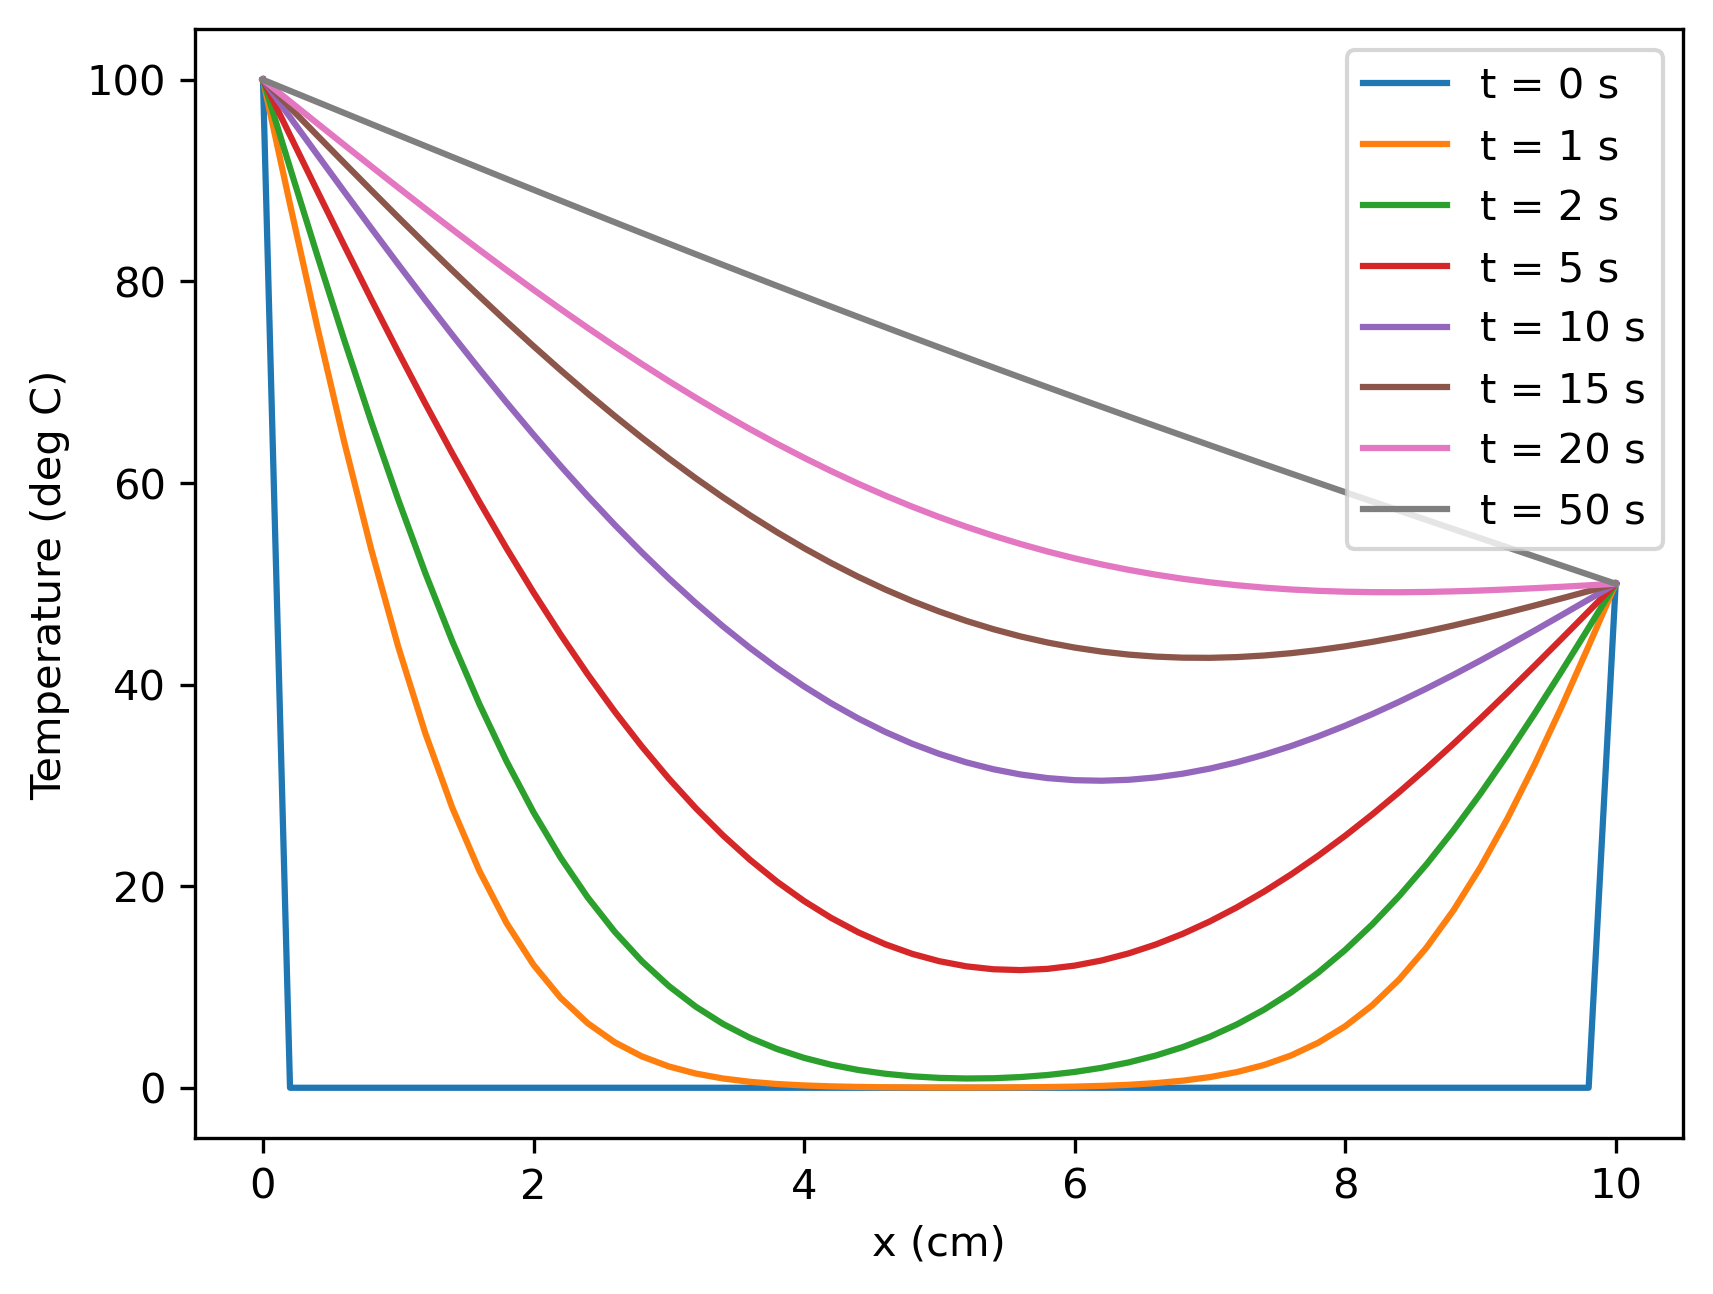

In [7]:
for ttp in times_to_plot:
    plt.plot(x, T[:, int(ttp/dt)], label = 't = %d s' % ttp)

plt.xlabel('x (cm)')
plt.ylabel('Temperature (deg C)')
plt.legend()
plt.show()

The solution looks about the same. The advantage of the BTCS method would be if we wanted to use a larger $\Delta t$ to improve efficiency, it is unconditionally stable.

In [8]:
T_implicit = T.copy() # save the results for later

------------
##### Crank-Nicolson method
3. Crank-Nicolson method

The setup is similar to the BTCS method, it is just a bit more involved to create the $\mathbf{b}$ vector each timestep.

In [9]:
T  = np.zeros((len(x),len(t)+1))

T[:,0] = 0 # initial condition
T[0,:] = 100 # left BC
T[-1,:] = 50  # right BC 

# LHS matrix A
main = 2*(1 + lmbda) * np.ones(len(x)-2) # length-2 removes BCs
off1 = -lmbda * np.ones(len(x)-3)
A = np.diag(main) + np.diag(off1,-1) + np.diag(off1,1)

# RHS matrix is also constant (call it M)
main = 2*(1 - lmbda) * np.ones(len(x)-2) 
off1 = lmbda * np.ones(len(x)-3)
M = np.diag(main) + np.diag(off1,-1) + np.diag(off1,1)

for l in range(len(t)):
    # b vector M * T^l plus BCs
    b = M @ T[1:-1,l].copy() # internal nodes only
    b[0] += 2 * lmbda * 100 # left BC
    b[-1] += 2 * lmbda*50 # right BC
     
    T[1:-1,l+1] = np.linalg.solve(A,b) # solve all internal nodes at this timestep

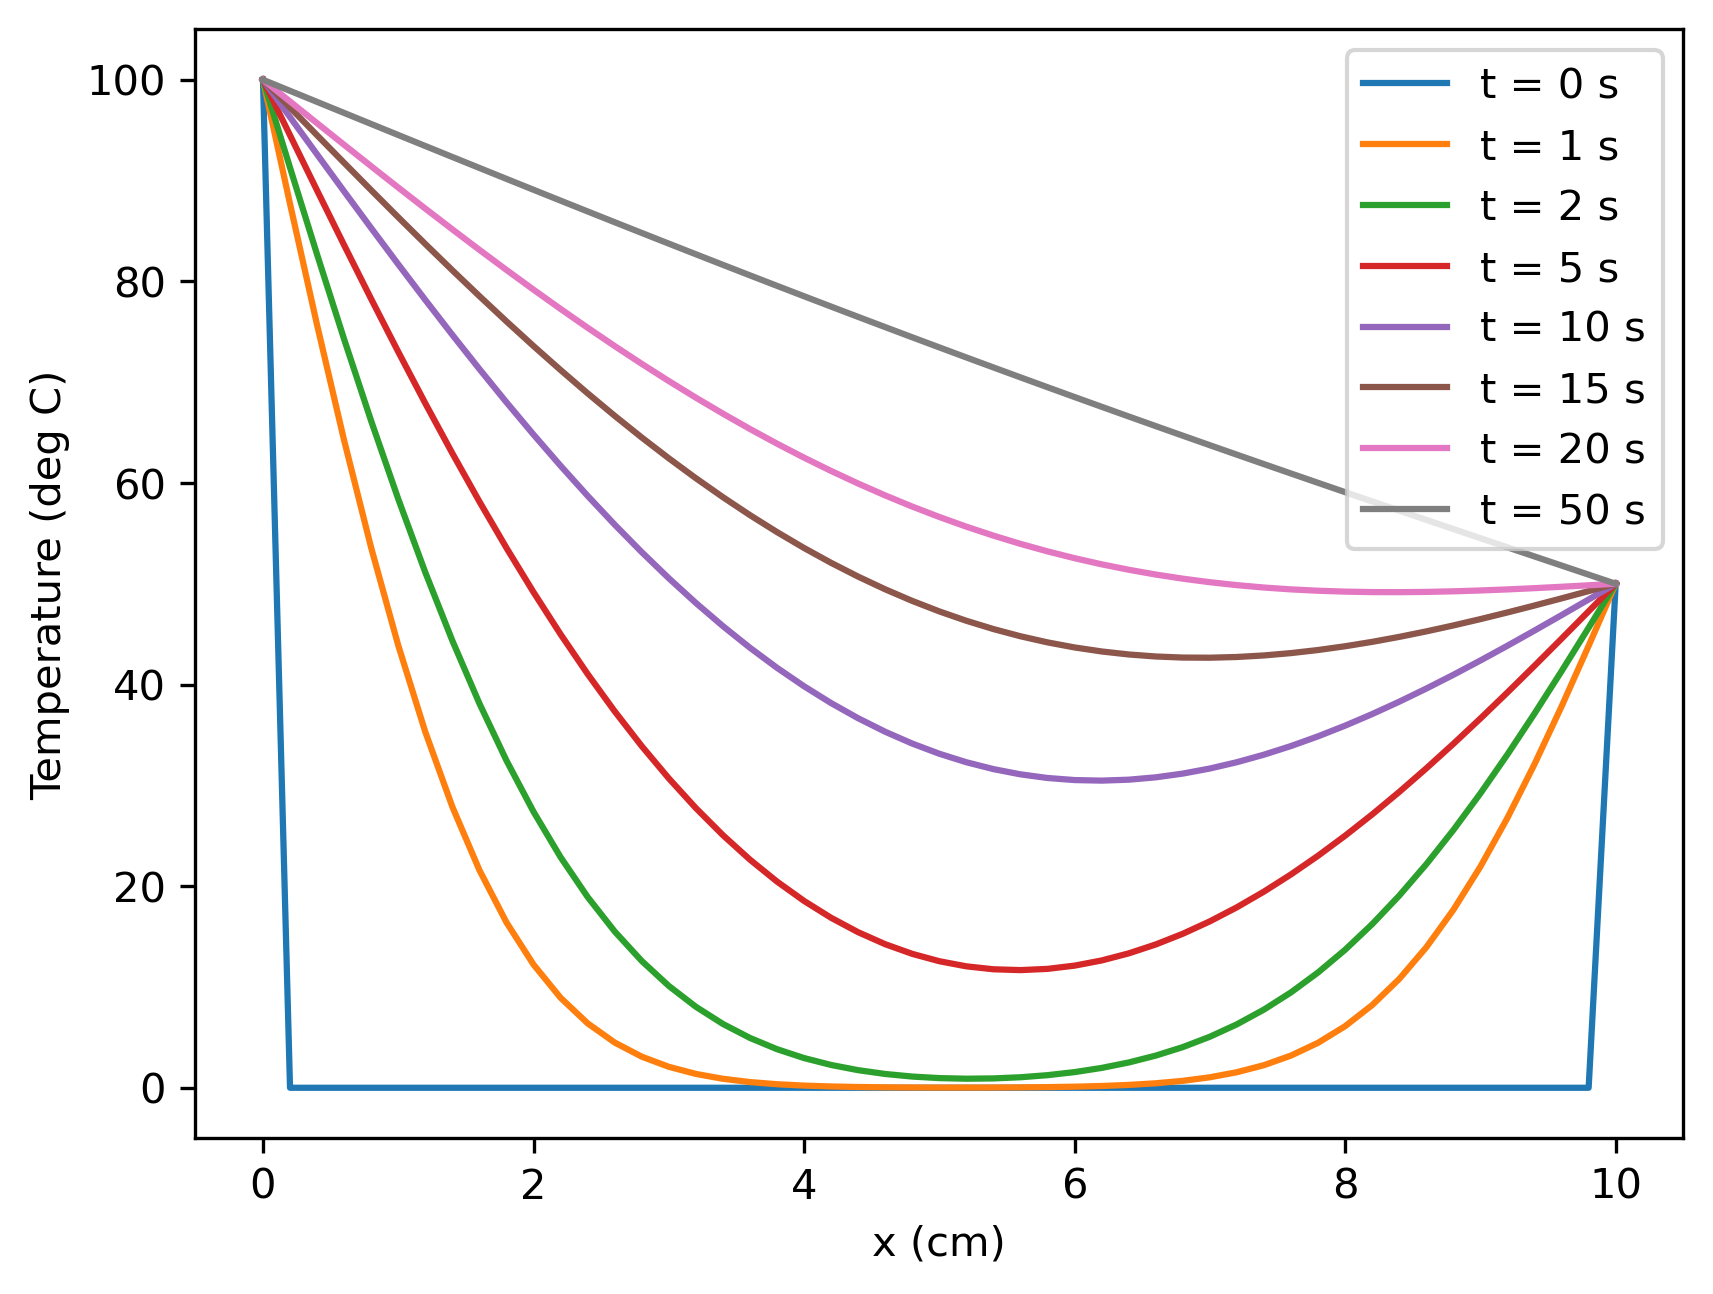

In [10]:
for ttp in times_to_plot:
    plt.plot(x, T[:, int(ttp/dt)], label = 't = %d s' % ttp)

plt.xlabel('x (cm)')
plt.ylabel('Temperature (deg C)')
plt.legend()
plt.show()

In [11]:
T_cn = T.copy()

-----------
##### Accuracy

Compare accuracy to analytical value: $T(x=2, t=10) = 64.8018$

In [12]:
exact = 64.8018

# percent relative error
err_explicit = np.abs(T_explicit[int(2/dx), int(10/dt)] - exact) / exact * 100
err_implicit = np.abs(T_implicit[int(2/dx), int(10/dt)] - exact) / exact * 100
err_cn = np.abs(T_cn[int(2/dx), int(10/dt)] - exact) / exact * 100

print(err_explicit)
print(err_implicit)
print(err_cn)

0.017462947628092317
0.019287407025270462
0.0009025066986259534


In this case we are using a small $\Delta t$, so all three methods are very accurate, though Crank-Nicolson is two orders of magnitude more accurate than the others. BTCS has essentially the same accuracy as FTCS, but with the advantage of unconditional stability (not shown here). Try testing the accuracy for different values of $\Delta t$, and compare to C&C Table 30.1.

##### Animation

Since we have the full matrix `T(x,t)` saved, we can also try animating `T(x)` over time. First create the initial plot axes, then update the line every `interval` steps. Note this will only animate when the cell is run. There are more advanced methods to save and embed animations in static webpages, for example see [here](https://jckantor.github.io/CBE30338/A.03-Animation-in-Jupyter-Notebooks.html).

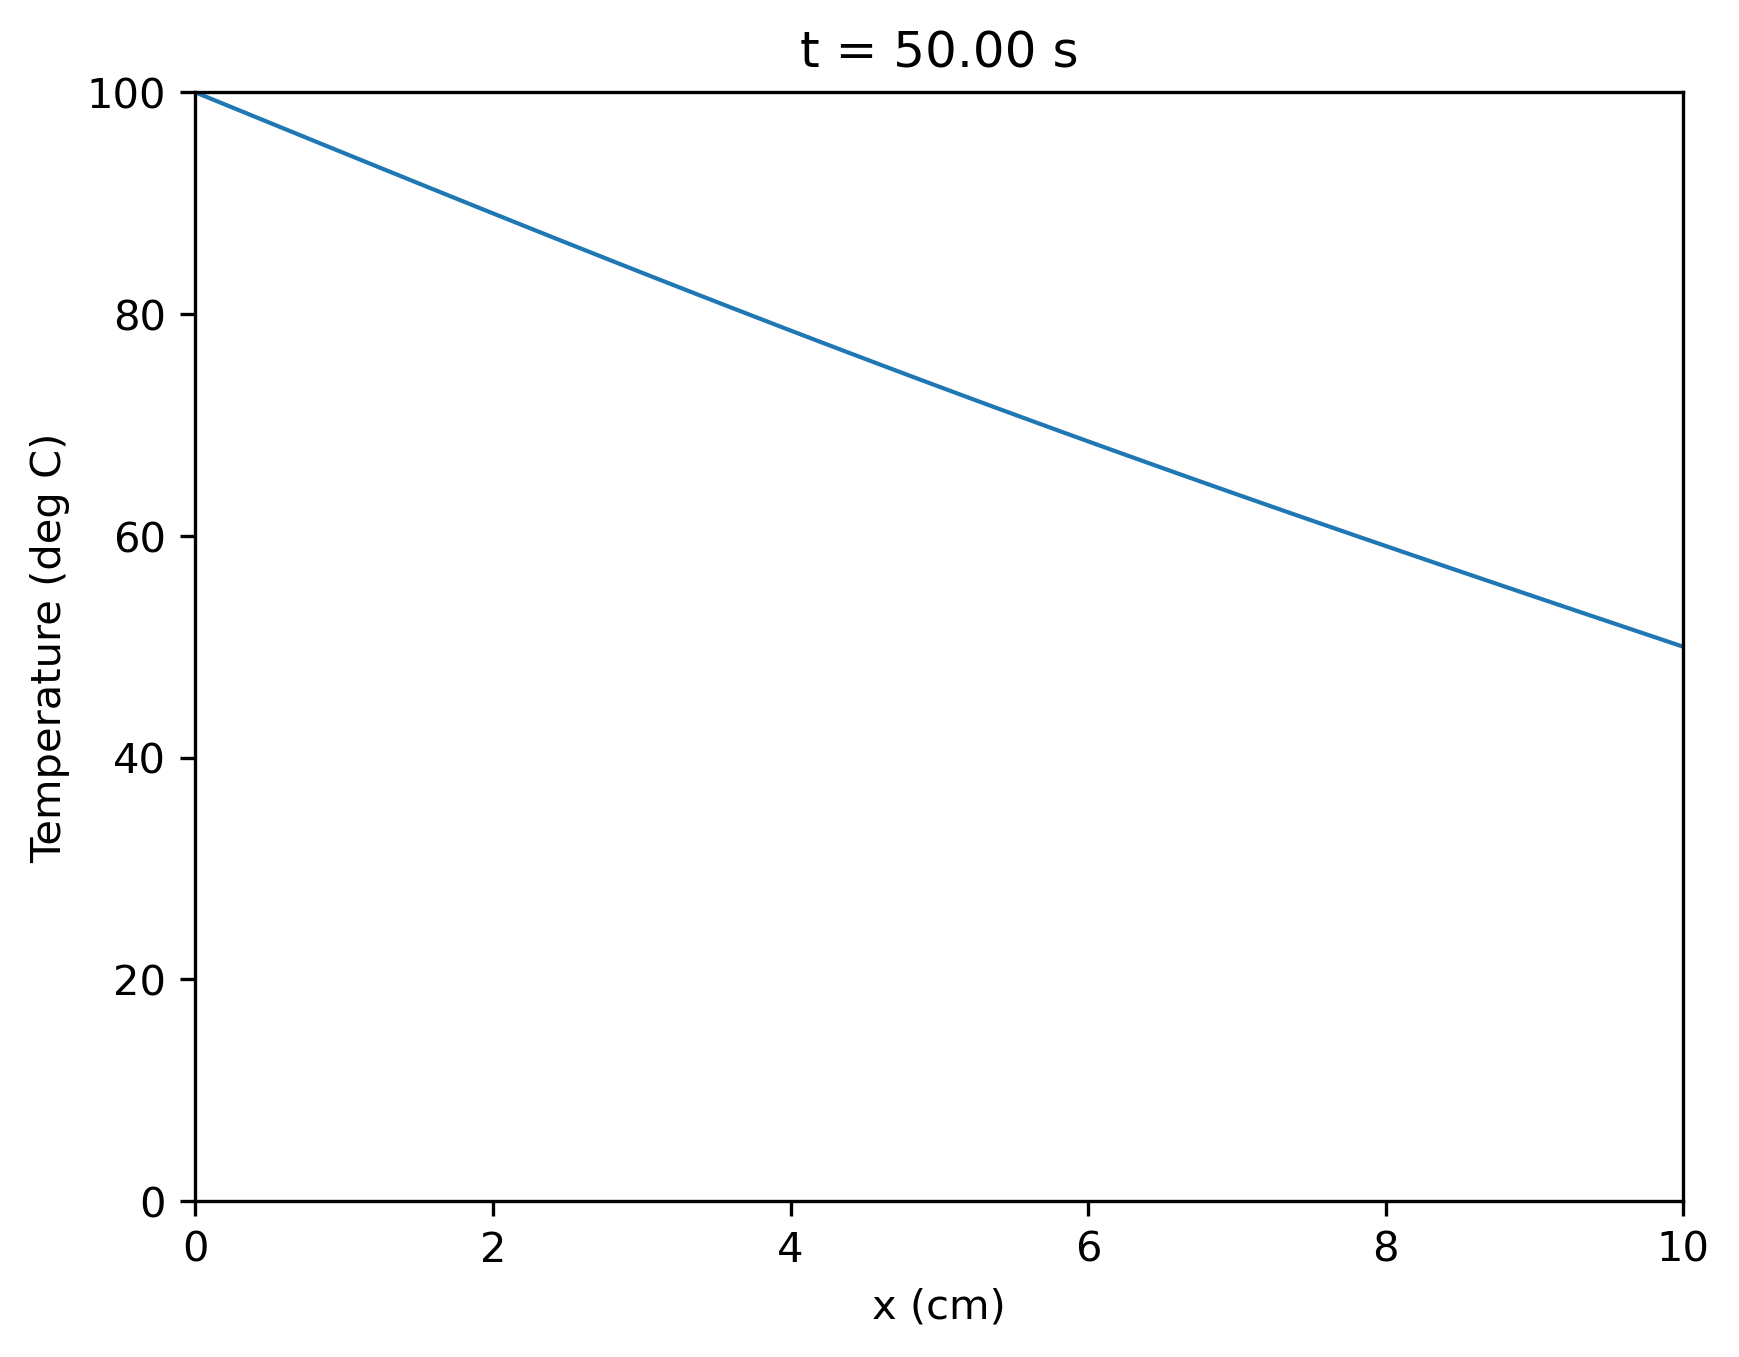

In [13]:
from IPython import display

fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 100))
h, = ax.plot(x, T[:,0], lw=1)
plt.xlabel('x (cm)')
plt.ylabel('Temperature (deg C)')

interval = 20 
for i in range(len(t)):
    if i % interval == 0:
        h.set_data(x, T[:,i])
        plt.title('t = %0.2f s' % (i*dt))
        display.display(plt.gcf())
        display.clear_output(wait =True)